In [1]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/home/students/s277665/.conda/envs/baseEnv/lib/python3.7/site-packages')
sys.path.append("/Users/francescoparino/Researchs/Mac2Mic/Util/")
sys.path.append("./matplotlib2tikz-0.7.6/")
#sys.path.append("./")

In [3]:
import pandas as pd
import numpy as np
import scipy as spy
import os
import copy

import itertools
from glob import glob
import seaborn as sns
import matplotlib.patches as mpatches
from collections import Counter
from collections import defaultdict
from itertools import combinations

from multiprocessing import Pool
from functools import partial

from tqdm import tqdm_notebook

import collections, functools, operator 
from bidict import bidict
from sklearn.decomposition import NMF
from matplotlib.colors import LogNorm


from datetime import timedelta
import pickle
from sklearn.cluster import KMeans

blues = np.array(sns.light_palette("blue"))[[-4,-1]]
purples = np.array(sns.light_palette("purple"))[[-4,-1]]

In [4]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import DivergingNorm
import matplotlib.ticker as mtick

In [5]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
from Covid_Lib_Data import readCovidDataset, readMorti
from Covid_Lib_Simulator import parameters, initialStates, oneStep

In [7]:
cPre = "r"
cAlphaDec = "g"
cAlphaCos = "b"
cTrueNew = blues[0]
cPredNew = blues[1]
cTrueCum = purples[0]
cPredCum = purples[1]

mpPre      = mpatches.Patch(color=cPre, label='Pre Lockdown', alpha=0.2)
mpAlphaDec = mpatches.Patch(color=cAlphaDec, label='Lockdown Adaptation', alpha=0.2)

mpTrueNew  = matplotlib.lines.Line2D([0], [0],color=cTrueNew, label='Deaths (data)', alpha=1)
mpPredNew  = matplotlib.lines.Line2D([0], [0],color=cPredNew, label='Deaths (model)', alpha=1)

mpTrvlBn  = matplotlib.lines.Line2D([0], [0],color="black", label='Travel Ban', alpha=1)

In [8]:
dictProvincieNS, dictRegionNS, orderedPROV, convertPROV_REG, nh, Whk, covidProv, covidRegion, covidRegionCum, covidRegionNew = readCovidDataset()
cvdRgDc_CUM, cvdRgDc_NEW = readMorti()

preDay = 23 #effective 20gg before
pre = pd.DataFrame((np.zeros((preDay, 20))), columns = cvdRgDc_CUM.columns, index=pd.date_range(cvdRgDc_CUM.index[0]-datetime.timedelta(preDay), periods=preDay, freq='1D'))
pre.loc["2020-02-21", "Lombardia"] = 1
pre.loc["2020-02-22", "Lombardia"] = 1
pre.loc["2020-02-23", "Lombardia"] = 4
pre.loc["2020-02-20", "Veneto"] = 1
pre = pre.cumsum()

cvdRgDc_CUM = cvdRgDc_CUM.append(pre).sort_index()
cvdRgDc_NEW = cvdRgDc_CUM.diff()

<AxesSubplot:>

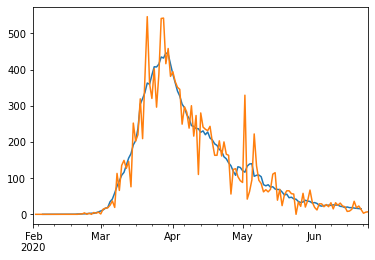

In [9]:
cvdRgDc_NEW["Lombardia"].rolling(7, center=True).mean().shift(0).dropna().plot(legend=False)
cvdRgDc_NEW["Lombardia"].plot(legend=False)

In [10]:
# Smooth
cvdRgDcRaw_NEW = cvdRgDc_NEW.copy().iloc[4:]
cvdRgDcRaw_CUM = cvdRgDc_CUM.copy().iloc[4:]
cvdRgDc_NEW = cvdRgDc_NEW.rolling(7, center=True).mean().dropna()
cvdRgDc_CUM = cvdRgDc_CUM.rolling(7, center=True).mean().dropna()

# Define Functions

In [11]:
def runTotal(SEINR, p, timeS=200, lockNord_b=None, lockSud_b=None, lockAll_alpha=None):
    S, E, I, N, R = SEINR
    
    time = np.arange(timeS)
    comSumForRegion = np.zeros((timeS, p.Whk.shape[0], 5))
    comSum = np.zeros((timeS, 5))
    rawSEINR = np.zeros((timeS, S.shape[0], p.Whk.shape[0], 5))

    
    # set and control alpha if negative
    if lockAll_alpha is not None:
        smoothDay = 15
        step = (1-p.alpha_lock)/smoothDay
        
        while lockAll_alpha < 0 and smoothDay>0: 
            lockAll_alpha += 1
            smoothDay -= 1
            p.alpha -= step
            
        
    # lockB negative
    if lockNord_b is not None:
        if lockNord_b < 0:  p.lockdown_b([dictProvincieNS[i] in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
    if lockSud_b is not None:
        if lockSud_b  < 0:  p.lockdown_b([dictProvincieNS[i] not in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
    

    for i in range(timeS):
        S, E, I, N, R = oneStep(SEINR,p) 
          
        rawSEINR[i] = np.dstack([S, E, I, N, R])
        comSumForRegion[i] = np.vstack([S.sum(0), E.sum(0), I.sum(0), N.sum(0), R.sum(0)]).transpose()
        comSum[i] = comSumForRegion[i].sum(0) #SEIAR
        SEINR = (S, E, I, N, R)
        
        if i == lockNord_b:
            p.lockdown_b([dictProvincieNS[i] in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
        if i == lockSud_b: 
            p.lockdown_b([dictProvincieNS[i] not in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
        
        if i >= lockAll_alpha and i < (lockAll_alpha+smoothDay):
            p.alpha -= step
            
    return time, comSum, comSumForRegion, rawSEINR



def getDataset(startDate, ggFit, initialEI_pos=-1, regionS=None):
    
    cvdRgDc_NEW_FIT = cvdRgDc_NEW[startDate: startDate + datetime.timedelta(days=ggFit)]
    cvdRgDc_CUM_FIT = cvdRgDc_CUM[startDate: startDate + datetime.timedelta(days=ggFit)]
    
    #Filter Regions
    if not regionS is None:
        cvdRgDc_CUM_FIT = cvdRgDc_CUM_FIT.loc[:, regionS]
        cvdRgDc_NEW_FIT = cvdRgDc_NEW_FIT.loc[:, regionS]
        
    #compute initial E,I
    initialCaseI = covidProv.iloc[initialEI_pos].values
    initialCaseE = covidProv.iloc[initialEI_pos].values
    
    realData = (cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, initialCaseI, initialCaseE)
    return realData



def fToMin(inp, realData, dateLocks, ggFit, provinceLevel=False, returnRaw=False):
    #init
    cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, initialCaseI, initialCaseE = realData
    Lambda, alpha_lock, b_lock, precentageE, precentageI = inp
    lockNord_b, lockSud_b, lockAll_alpha = dateLocks
    
    p = parameters(nh, Whk, Lambda=Lambda, alpha_lock=alpha_lock, b_lock=b_lock, precentageE=precentageE, precentageI=precentageI)        
    SEINR = initialStates(p, initialCaseI, initialCaseE)

    #run
    time, comSum, comSumForRegion, rawSEINR = runTotal(SEINR, p, ggFit+1, lockNord_b, lockSud_b, lockAll_alpha)
    if returnRaw: return comSum,comSumForRegion,rawSEINR
    
    
    #crete timeseries from results
    mdlI = pd.DataFrame(comSumForRegion[:, :, 2], columns=orderedPROV)
    mdlI.index = pd.date_range(mdlI.index[0], periods=len(mdlI), freq='1D') 
    
    
    #newI 
    S = pd.DataFrame(comSumForRegion[:, :, 0], columns=orderedPROV)
    S.index = pd.date_range(S.index[0], periods=len(S), freq='1D') 
    E = pd.DataFrame(comSumForRegion[:, :, 1], columns=orderedPROV)
    E.index = pd.date_range(E.index[0], periods=len(E), freq='1D') 
    mdlINew = - (E - E.shift(1) - (S.shift(1) - S))

    
    mdlDc_CUM = pd.DataFrame((rawSEINR[:, :, :, 4] * p.mortality.reshape(1, 2, 1)).sum(1), columns=orderedPROV)
    mdlDc_CUM.index = pd.date_range(cvdRgDc_CUM_FIT.index[0], periods=len(mdlDc_CUM), freq='1D')     
    
    if provinceLevel:
        return mdlI, mdlDc_CUM
    
    # rename axix to match dataset
    mdlI.columns = [convertPROV_REG[i] for i in mdlI.columns]
    mdlI = mdlI.groupby(level=0, axis=1).sum()
    
    mdlINew.columns = [convertPROV_REG[i] for i in mdlINew.columns]
    mdlINew = mdlINew.groupby(level=0, axis=1).sum()
    
    mdlDc_CUM.columns = [convertPROV_REG[i] for i in mdlDc_CUM.columns]
    mdlDc_CUM = mdlDc_CUM.groupby(level=0, axis=1).sum()
    
    
    
    return mdlINew, mdlDc_CUM

# DEFINE EXPERIMENTS

In [12]:
# Time Period Fit
initialEI_pos_BEST = -1
startDate = cvdRgDc_CUM.index[0]
ggFit_BEST = list(cvdRgDc_CUM.index).index(cvdRgDc_CUM.loc["2020-05-18"].name)

# Lock-down strategies
lockNord_b_BEST = (datetime.datetime(2020, 3, 1) - startDate).days
lockSud_b_BEST = (datetime.datetime(2020, 3, 7) - startDate).days
lockAll_alpha_BEST = (datetime.datetime(2020, 3, 5) - startDate).days

In [13]:
startDate

Timestamp('2020-02-04 00:00:00')

In [14]:
GG_EXP = (datetime.datetime(2020, 5, 18) - startDate).days
GG_EXP

104

In [15]:
{'Lambda': 0.04218151748264074, 'alpha_lock': 0.17657372198907198, 'b_lock': 0.0, 'initialE': -3.6060057687708658, 'initialI': -2.1024724516951636}

{'Lambda': 0.04218151748264074,
 'alpha_lock': 0.17657372198907198,
 'b_lock': 0.0,
 'initialE': -3.6060057687708658,
 'initialI': -2.1024724516951636}

In [23]:
B_LOW_BEST = 0
ALPHA_LOW_BEST = 0.17657372198907198

Lambda = 0.04218151748264074
initialE = -3.6060057687708658
initialI = -2.1024724516951636

In [24]:
def getExperiment(lockNord_b, lockSud_b, lockAll_alpha, alpha_low, b_low, ggFit=ggFit_BEST, provinceLevel=False):
    par = [Lambda,  alpha_low,  b_low, initialE, initialI]
    realData = getDataset(startDate, ggFit, initialEI_pos_BEST)
    dateLocks = lockNord_b, lockSud_b, lockAll_alpha
    
    mdlI, mdlDc_CUM = fToMin(par, realData, dateLocks, ggFit, provinceLevel=provinceLevel)
    return mdlI, mdlDc_CUM

In [25]:
lockAll_alpha_R = (datetime.datetime(2020, 3, 5) - startDate).days
lockAll_alpha_B = lockAll_alpha_R - 15
lockAll_alpha_BB = lockAll_alpha_R - 26
lockAll_alpha_A = lockAll_alpha_R + 14

lock_b_R = (datetime.datetime(2020, 3, 1) - startDate).days
lock_b_B = lock_b_R - 15
lock_b_BB = lock_b_R - 26
lock_b_A = lock_b_R + 14

# RUN

In [26]:
def getPrevalenceMax(alphaLow_low, alphaHi_low, b_low, lockNord_b, lockSud_b, lockAll_alpha):
    ggFit = GG_EXP
    alpha_low = np.array([alphaLow_low, alphaHi_low])

    par = [Lambda,  alpha_low,  b_low, initialE, initialI]
    realData = getDataset(startDate, ggFit, initialEI_pos_BEST)
    dateLocks = lockNord_b, lockSud_b, lockAll_alpha

    mdlINew, mdlDc_CUM = fToMin(par, realData, dateLocks, ggFit_BEST)
    return alphaHi_low, alphaLow_low, mdlDc_CUM.sum(1).max()

In [27]:
# make grid and iterate

lock_b = lock_b_R
lock_alpha = lockAll_alpha_R
alphaLowGrid = np.linspace(0, 0.8, 20)
alphaHiGrid = np.linspace(0, 0.8, 20)

gird = itertools.product(alphaLowGrid, alphaHiGrid)
with Pool(12) as pool:
    f = partial(getPrevalenceMax, b_low=B_LOW_BEST, lockNord_b=lock_b, lockSud_b=lock_b, lockAll_alpha=lock_alpha)
    res = pool.starmap(f, gird)
    
res = [(i,j,pd.Series(k, index=["Italy"])) for i,j,k in res]

_, _, BEST_deaths = getPrevalenceMax(ALPHA_LOW_BEST, ALPHA_LOW_BEST, b_low=B_LOW_BEST, lockNord_b=lock_b, lockSud_b=lock_b, lockAll_alpha=lock_alpha)

In [28]:
resTot = pd.DataFrame([(i, j, k["Italy"]) for i,j,k in res], columns=["alpha_low", "b_low", "prevalence"]).set_index(["alpha_low", "b_low"]).unstack().droplevel(0, 1)
resTot.sort_index(ascending=False, inplace=True)

<a list of 4 text.Text objects>

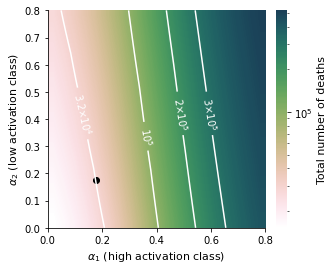

In [30]:
import matplotlib.ticker as ticker

def getLogColor(data, vmin=None, vmax=None): 
    if vmin is None: vmin=data.min().min()
    if vmax is None: vmax=data.max().max()
    
    log_norm = LogNorm(vmin=vmin, vmax=vmax)
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(vmin)), math.ceil(math.log10(vmax)))]
    return log_norm, cbar_ticks



fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(5, 4))

cmap = sns.cubehelix_palette(8, start=0, rot=-.8, gamma = .8, hue=1, light=1, as_cmap=True)
log_norm, cbar_ticks = getLogColor(resTot)
        
mapp = plt.imshow(resTot, interpolation="bilinear",  extent=[0,0.8,0,0.8], cmap=cmap, norm=log_norm)

X, Y = np.meshgrid(resTot.columns, resTot.index)
CS = ax.contour(X, Y, resTot, levels=[BEST_deaths, 1e5, 2e5, 3e5], colors="white")

cb = fig.colorbar(mapp, ax=ax, fraction=0.04, pad=0.04, label=f"Total number of deaths")
cb.outline.set_visible(False)


ax.set_xlabel(f"$\\alpha_1$ (high activation class)")
ax.set_ylabel(f"$\\alpha_2$ (low activation class)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

plt.scatter(ALPHA_LOW_BEST, ALPHA_LOW_BEST, color="black")

maxInd = resTot.index[np.unravel_index(resTot.values.argmax(), resTot.values.shape)[0]]
maxCol = resTot.columns[np.unravel_index(resTot.values.argmax(), resTot.values.shape)[1]]
maxVal = resTot.values.max()


f = ticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x : "${}$".format(f._formatSciNotation('%1.1e' % x))
ax.clabel(CS, inline=1, fontsize=10, fmt=g)


#plt.savefig("./close_LockMirati/60annith.pdf", bbox_inches = "tight")